## Configuración e importación de librerías


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import sys
import os


## Carga de los datos

El conjunto de datos de ChestX-ray8 se puede encontrar en https://nihcc.app.box.com/v/ChestXray-NIHCC/, una opción es descargar la carpeta con las imágenes en un .zip pero NIH ya proporciona .py capaz de descargar y descomprimir los archivos de las imágenes. Ese archivo ha sido modificado para descargar las imágenes en una carpeta más conveniente con la estructura del proyecto.

In [9]:
data_dir = Path.cwd().parent / 'data'

In [10]:
# Check if we have all images
images_dir = data_dir / 'images'
images_dir.mkdir(parents=True,exist_ok=True)

# Check info
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]


print(f"Number of images: {len(image_files)}")
if len(image_files)<1:
    
    !python ../src/batch_download_zips_modifed.py
    !python ../src/unzip_images.py

Number of images: 112120


In [13]:
# Metadata path
metadata_dir = data_dir / 'metadata' / 'Data_Entry_2017_v2020.csv'
bbox_dir =  data_dir /'metadata'/'BBox_List_2017.csv'


metadata_df = pd.read_csv(metadata_dir)
print(f"Unique patients: {metadata_df['Patient ID'].nunique()}")
display(metadata_df.head())


Unique patients: 30805


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


## Análisis de las etiquetas y patologías

C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_13696\327770512.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


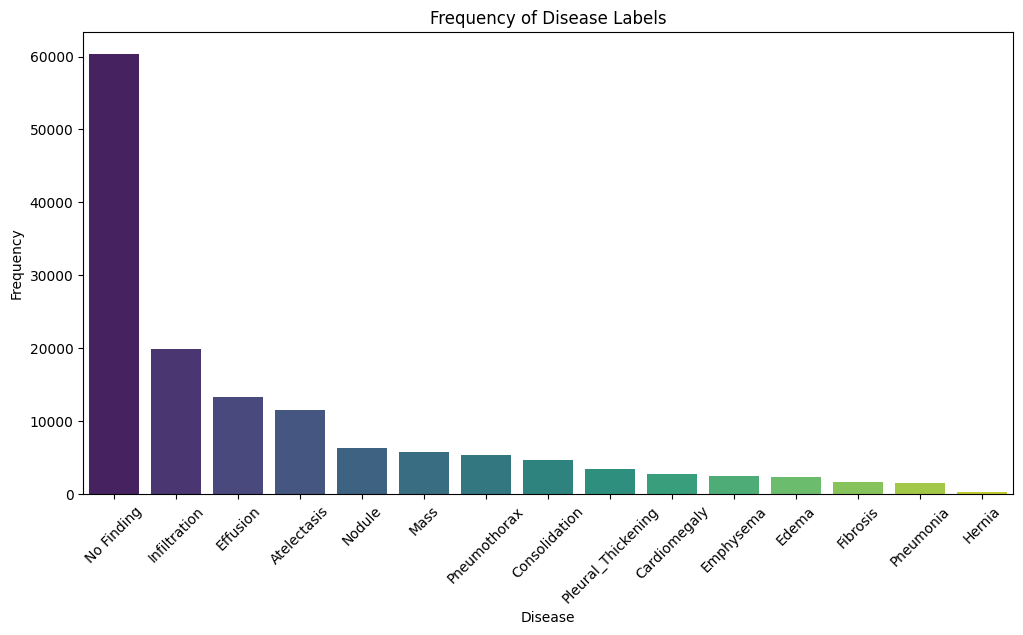

Number of multi-label cases: 20796


In [14]:
# Split 'Finding Labels' into individual labels
metadata_df['Labels List'] = metadata_df['Finding Labels'].str.split('|')

# Calculate freq of each label
all_labels = metadata_df['Labels List'].explode()
label_counts = all_labels.value_counts()

# Plot label distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Frequency of Disease Labels")
plt.xlabel("Disease")
plt.ylabel("Frequency")
plt.show()

# Check for multi-label cases
metadata_df['Label Count'] = metadata_df['Labels List'].apply(len)
multi_label_cases = metadata_df[metadata_df['Label Count'] > 1]
print(f"Number of multi-label cases: {len(multi_label_cases)}")



### Distribución de datos por paciente

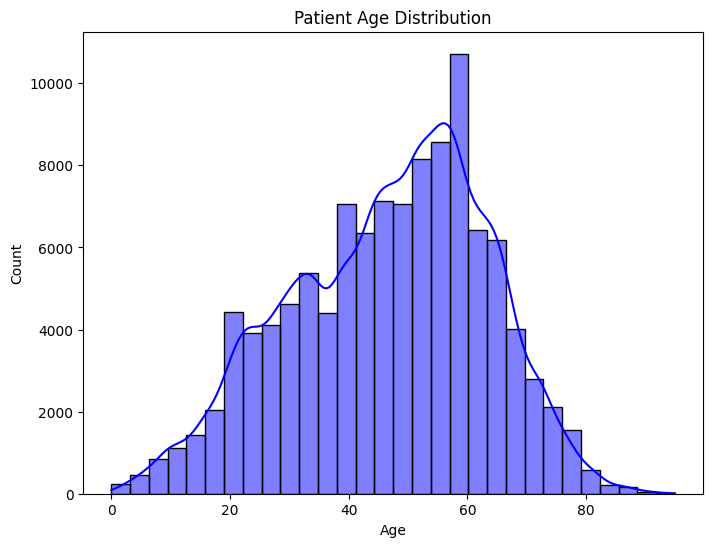

C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_13696\2489577500.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')


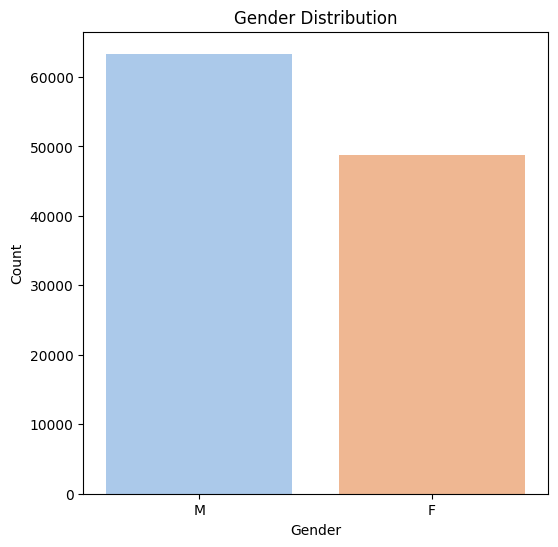

C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_13696\2489577500.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=view_counts.index, y=view_counts.values, palette='muted')


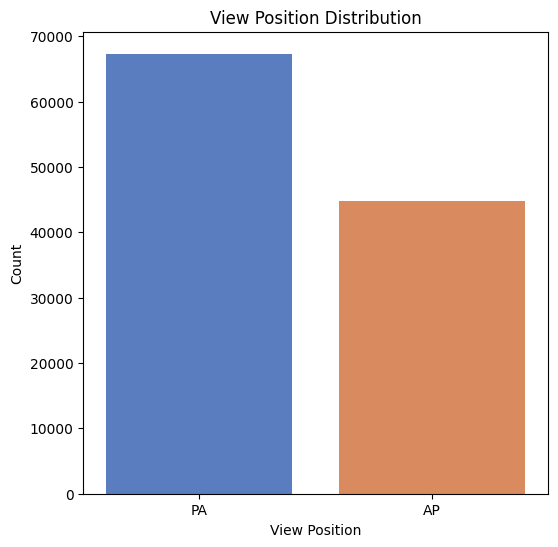

In [15]:
# Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(metadata_df['Patient Age'], bins=30, kde=True, color='blue')
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Gender distribution
gender_counts = metadata_df['Patient Gender'].value_counts()
plt.figure(figsize=(6, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# View Position analysis
view_counts = metadata_df['View Position'].value_counts()
plt.figure(figsize=(6, 6))
sns.barplot(x=view_counts.index, y=view_counts.values, palette='muted')
plt.title("View Position Distribution")
plt.xlabel("View Position")
plt.ylabel("Count")
plt.show()


## Labeled images

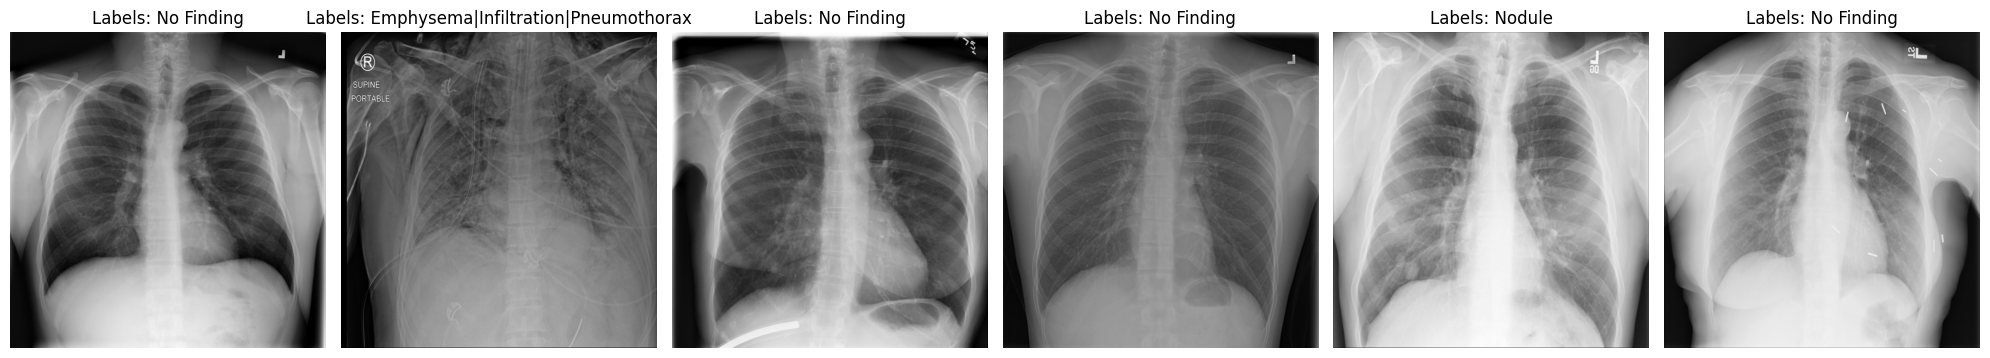

In [16]:
# Function to display sample images with labels
def display_sample_images(metadata, images_dir, n_samples=6):
    sample = metadata.sample(n_samples)
    fig, axes = plt.subplots(1, n_samples, figsize=(20, 10))
    
    for idx, (index, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(images_dir, row['Image Index'])
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"Labels: {row['Finding Labels']}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 6 random X-ray images
display_sample_images(metadata_df, images_dir, n_samples=6)


## Bounding Boxes

In [17]:
bbox_df = pd.read_csv(bbox_dir)
print("Número de imágenes con bounding boxes:", bbox_df.shape[0])
bbox_df.head()


Número de imágenes con bounding boxes: 984


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


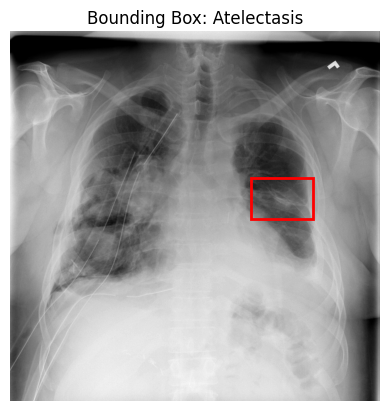

In [18]:
# Join metadata with bounding box data
bbox_sample = bbox_df.sample(1)
bbox_sample

# Visualize image with bounding box
img_path = os.path.join(images_dir, bbox_sample.iloc[0]['Image Index'])
img = Image.open(img_path).convert("L")
plt.imshow(img, cmap='gray')

# Plot bounding box
x, y, w, h = bbox_sample.iloc[0][['Bbox [x', 'y', 'w', 'h]']]
plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
plt.title(f"Bounding Box: {bbox_sample.iloc[0]['Finding Label']}")
plt.axis('off')
plt.show()



## Co-ocurrence

                                   Pair  Count
4              (Effusion, Infiltration)   3998
31              (Atelectasis, Effusion)   3270
38          (Atelectasis, Infiltration)   3260
12               (Infiltration, Nodule)   1545
52            (Consolidation, Effusion)   1287
..                                  ...    ...
95                     (Mass, Effusion)      1
115  (Pleural_Thickening, Infiltration)      1
116        (Pleural_Thickening, Nodule)      1
117            (Fibrosis, Cardiomegaly)      1
118                (Mass, Cardiomegaly)      1

[119 rows x 2 columns]


ValueError: Names should be list-like for a MultiIndex

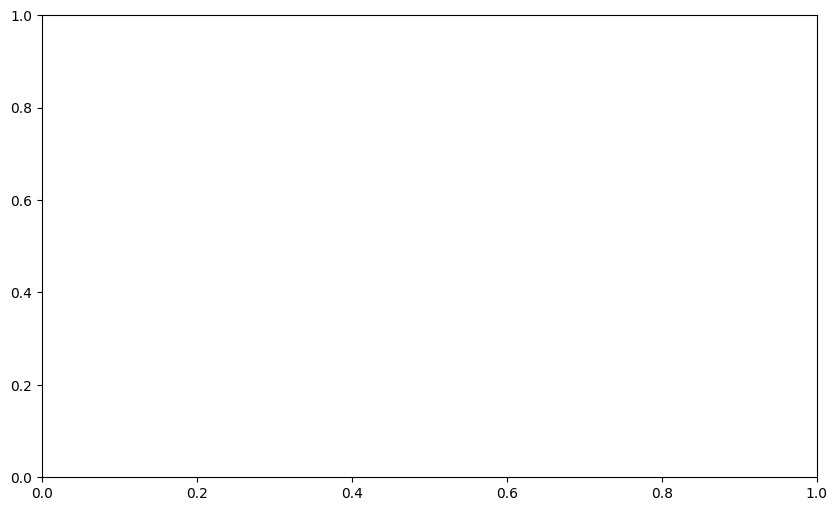

In [19]:
# Create a co-occurrence matrix
from itertools import combinations
from collections import Counter

# Count label pairs
pair_counts = Counter(
    comb
    for label_list in metadata_df['Labels List']
    for comb in combinations(label_list, 2)
)

# Convert to DataFrame for plotting
pair_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Count'])
pair_df = pair_df.sort_values(by='Count', ascending=False)
print(pair_df)
# Plot top 10 co-occurring pairs
plt.figure(figsize=(10, 6))
sns.barplot(x=pair_df['Count'][:10], y=pair_df['Pair'][:10], palette='cool')
plt.title("Top 10 Co-occurring Disease Pairs")
plt.xlabel("Count")
plt.ylabel("Disease Pair")
plt.show()
